In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lilith.lilith_utils import *
import warnings
from wotan import flatten
import visualize as vis

from dataloading import loading as dl

from detection import bls_detection as bls_det
from detection import rnn_detection as rnn_det

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
def read_dvdic(path):
    with open(path, "rb") as f:
        dvdic = pickle.load(f)
    return dvdic

In [3]:
dv_all = read_dvdic("data/lilith/dv/dv_dic.pkl")
dv_sect = {}
for i in [1,2,3,4]:
    dv_sect[i] = read_dvdic(f"data/lilith/sector{i}/dv/dv_dic.pkl")

In [4]:
len(dv_all), len(dv_sect[1]), len(dv_sect[2]), len(dv_sect[3]), len(dv_sect[4])

(1256, 498, 601, 592, 490)

In [5]:
BASE_PATH = "data/lilith"
SECTOR = {i:f"/sector{i}" for i in [1,2,3,4]}  # use as: path = BASE_PATH + SECTOR[i]
[BASE_PATH + "/" + dirname for dirname in os.listdir(BASE_PATH) if os.path.isdir(BASE_PATH + "/" + dirname)]

# load ground-truth and sector sampleids
sampleids_sector = {i:sampleids_from_curl(BASE_PATH+SECTOR[i]+'/fits') for i in SECTOR}
sampleids = set()
for i in SECTOR:
    sampleids.update(sampleids_sector[i])
sampleids = np.array(list(sampleids))

gt_sector = {i:{obj:{} for obj in ["pl", "eb", "beb"]} for i in SECTOR}
gt = {obj:{"params":{}, "sampleids":[]} for obj in ["pl", "eb", "beb"]}
for i in SECTOR:
    gt_path = BASE_PATH+SECTOR[i]+'/ground_truth'
    gt_sector[i]["pl"]["params"], gt_sector[i]["pl"]["sampleids"] = get_pl_data(gt_path, sampleids_sector[i])
    gt_sector[i]["eb"]["params"], gt_sector[i]["eb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=0)
    gt_sector[i]["beb"]["params"], gt_sector[i]["beb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=1)
    for obj in ["pl", "eb", "beb"]:
        for sampleid, obj_data in gt_sector[i][obj]["params"].items():  
            if sampleid in gt[obj]["sampleids"]:
                # ground truth already saved from prev sector
                if obj_data != gt[obj]["params"][sampleid]:
                    print("WARNING: inconsistent ground-truth data")
            elif obj_data != {}:
                gt[obj]["params"][sampleid] = obj_data
                gt[obj]["sampleids"].append(sampleid)
for obj in ["pl", "eb", "beb"]:
    gt[obj]["sampleids"] = np.array(gt[obj]["sampleids"])
    for sampleid in sampleids:
        if sampleid not in gt[obj]["sampleids"]:
            gt[obj]["params"][sampleid] = {}

In [6]:
# select test samples and display statistics
test_sampleids = {obj:set() for obj in ["all", "pl", "eb", "beb"]}  # not to be used for training

def inter(a, b):
    return np.intersect1d(a, b)

for i1 in SECTOR:
    for i2 in SECTOR:
        if i2 > i1:
            s_ids = inter(sampleids_sector[i1], sampleids_sector[i2])
            pl_ids = inter(gt_sector[i1]["pl"]["sampleids"], gt_sector[i2]["pl"]["sampleids"])
            eb_ids = inter(gt_sector[i1]["eb"]["sampleids"], gt_sector[i2]["eb"]["sampleids"])
            beb_ids = inter(gt_sector[i1]["beb"]["sampleids"], gt_sector[i2]["beb"]["sampleids"])
            
            test_sampleids["all"].update(s_ids), test_sampleids["pl"].update(pl_ids)
            test_sampleids["eb"].update(eb_ids), test_sampleids["beb"].update(beb_ids)

In [7]:
pl_ids_corrected = []
for s_id in test_sampleids["pl"]:
    if (s_id not in test_sampleids["eb"]) and (s_id not in test_sampleids["beb"]):
        pl_ids_corrected.append(s_id)
pl_ids_corrected= np.array(pl_ids_corrected)

In [8]:
def get_trange(sector):
    with open(f"data/lilith/sector{sector}/raw_batches/test/00000-00249", "rb") as f:
        b = pickle.load(f)
    return (b["time"][0][0], b["time"][0][-1])
sector_range = {i:get_trange(i) for i in [1,2,3,4]}

In [9]:
def consec_sectors(sec_str, only_two=False):
    consec = 0
    for s in sec_str:
        if s=="1":
            consec += 1
        elif consec and s=="0":
            return False
    if only_two:
        if consec != 2:
            return False
    return True

def consec_from_data(times, only_two=False):
    if len(times)==1:
        print("WARNING: test sample with only one sector")
    t_cat = np.concatenate(times)
    if np.max(np.diff(t_cat))>10:
        return False
    if only_two and len(times) > 2: 
        return False
    return True

def retrieve_sector(time):
    midt = np.nanmean(time)
    for s in sector_range:
        if midt > sector_range[s][0] and midt < sector_range[s][1]:
            return s

In [10]:
consec = {}
excluded = []
pbar = tqdm(os.listdir("data/eval/lilith/processed_nn_basic"))
for fname in pbar:
    try:
        with open("data/eval/lilith/processed_nn_basic/"+fname, "rb") as f:
            b = pickle.load(f)
        for s_id, data in b.items():
            if s_id in pl_ids_corrected:
                if len(data["time"])==0:
                    excluded.append(s_id)
                    continue
                consec[s_id] = consec_from_data(data["time"], only_two=1)
    except:
        pbar.close()
        raise

  5%|▌         | 1/20 [00:00<00:18,  1.02it/s]

 70%|███████   | 14/20 [00:12<00:05,  1.14it/s]

100%|██████████| 20/20 [00:18<00:00,  1.09it/s]

In [11]:
for s_id in excluded:
    keep = pl_ids_corrected!=s_id
    pl_ids_corrected = pl_ids_corrected[keep]

In [100]:
def fix_t0(t0, period, sectors, warnings=False):
    sectors = sectors if isinstance(sectors, list) else [sectors]
    tt = t0
    while tt < sector_range[sectors[0]][0]:
        tt += period
    while tt > sector_range[sectors[0]][0]:
        tt -= period
    
    if tt + period > sector_range[sectors[-1]][1] and warnings:
        print(f"WARNING: period too large to fix t0 (p = {round(period,2)} days)")
    return tt + period

def accept_planet(pl_data, sectors):
    sectors = sectors if isinstance(sectors, list) else [sectors]
    tt = fix_t0(pl_data["t0"], pl_data["orb_period"], sectors)
    if pl_data["orb_period"] < 2:
        return False
    n_transits = 0
    while tt < sector_range[sectors[-1]][1]:
        n_transits += 1
        tt += pl_data["orb_period"]
    if n_transits < 3:
        return False
    return True  

In [61]:
targets_sect = {i:{} for i in [1,2,3,4]}
rejected_sect = {i:{} for i in [1,2,3,4]}

for sector in [1,2,3,4]:
    for s_id in pl_ids_corrected:
        if s_id in gt_sector[sector]["pl"]["params"]:
            targets_sect[sector][s_id] = {}
            rejected_sect[sector][s_id] = {}
            for pl_i, pl_data in gt_sector[sector]["pl"]["params"][s_id].items():
                if accept_planet(pl_data, sector):
                    targets_sect[sector][s_id][pl_i] = pl_data
                else:
                    rejected_sect[sector][s_id][pl_i] = pl_data

In [17]:
# load_path = "data/eval/lilith/processed_bls_12h_outlier"
# write_path = "results/bls_multi_3it_outlier_detections"

# fnames = [fnm for fnm in os.listdir(load_path) if not fnm.startswith(".")]
# utils.make_dir(write_path)
# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         bls_detections = {i:{} for i in [1,2,3,4,0]}
#         batch = dl.load_data(load_path + "/"+ fname)
#         if batch is None:
#             continue
        
#         for sampleid in batch:
#             if sampleid in pl_ids_corrected:
#                 for i in range(len(batch[sampleid]["time"])):
#                     time = batch[sampleid]["time"][i]
#                     sector = retrieve_sector(time)
#                     flat = batch[sampleid]["flux"][i]
#                     detections = bls_det.algorithm(time, flat, num_iters=3)
#                     bls_detections[sector][sampleid] = detections

# #                 if consec[sampleid]:
# #                     time = np.concatenate(batch[sampleid]["time"])
# #                     flat = np.concatenate(batch[sampleid]["flux"])
# #                     detections = bls_det.algorithm(time, flat, min_transits=5, num_iters=3, freq_fac=6)
# #                     bls_detections[0][sampleid] = detections
#         with open(write_path + "/" +fname, "wb") as f:
#             pickle.dump(bls_detections, f) 
#     except:
#         pbar.close()
#         raise

# # combine bls_detections
# bls_detections_sect = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# for fnm in os.listdir("results/bls_multi_3it_detections"):
#     with open("results/bls_multi_3it_detections/"+fnm, "rb") as f:
#         b = pickle.load(f)
#     for i in [1,2,3,4]:
#         bls_detections_sect[i] = {**bls_detections_sect[i], **b[i]}
# with open("results/bls_multi_3it_detections.pkl", "wb") as f:
#     pickle.dump(bls_detections_sect, f)

In [128]:
# rnn_detections_sect = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# pbar = tqdm(os.listdir("data/eval/lilith/nn_basic_pts"))
# for fnm in pbar:
#     try:
#         if not fnm.startswith("."):
#             with open("data/eval/lilith/nn_basic_pts/"+fnm, "rb") as f:
#                 b_pts = pickle.load(f)
#             with open("data/eval/lilith/processed_nn_basic/"+fnm, "rb") as f:
#                 b = pickle.load(f)

#             for s_id in b:
#                 for i in range(len(b[s_id]["time"])):
#                     sector = retrieve_sector(b[s_id]["time"][i])
#                     detected = rnn_det.algorithm1(b_pts[s_id][i].copy(), num_iters=3, 
#                                                   min_transits=3, p_min=2, p_max=None, step_mult=2, 
#                                                   smooth=True, peak_frac=2, show_steps=False)
#                     print(detected)
#                     rnn_detections_sect[sector][s_id] = detected
#     except:
#         pbar.close()
#         raise

# with open("results/rnn_multi_3it_detections.pkl", "wb") as f:
#     pickle.dump(rnn_detections_sect, f)

In [62]:
pipeline_detections_sect = {i:{} for i in [1,2,3,4]}
for sector in [1,2,3,4]:
    for s_id in pl_ids_corrected:
        if s_id in gt_sector[sector]["pl"]["params"]:
            pipeline_detections_sect[sector][s_id] = {}
            if s_id in dv_sect[sector] and dv_sect[sector][s_id]["n_transit"] >= 3 \
            and dv_sect[sector][s_id]["period"] >= 2:
                snr = dv_sect[sector][s_id]["snr"]
                pipeline_detections_sect[sector][s_id][snr] = dv_sect[sector][s_id]

In [63]:
with open("results/bls_multi_3it_detections.pkl", "rb") as f:
    bls_detections_sect = pickle.load(f)

In [135]:
with open("results/rnn_multi_3it_detections.pkl", "rb") as f:
    rnn_detections_sect = pickle.load(f)

In [111]:
def correct_detection(detection, gt_params, sectors, per_frac=0.01, dur_factor=1, warnings=True):
    
    true_per = gt_params["orb_period"]
    true_t0 = fix_t0(gt_params["t0"], true_per, sectors, warnings=warnings)
    dur = gt_params["duration"]
    
    pred_per = detection["period"]
    pred_t0 = detection["t0"]
        
    per_correct = ((1-per_frac)*true_per <= pred_per) and (pred_per <= (1+per_frac)*true_per)
    t0_correct = ((true_t0-0.5*dur_factor*dur) <= pred_t0) and (pred_t0 <= (true_t0+0.5*dur_factor*dur))
    
    return (per_correct and t0_correct), per_correct, t0_correct

def evaluate_thresholds(detections, thresholds, warnings=True):
    snames = ["tp", "fp", "fn", "tn"]
    didx = list(detections.keys())[0]
    results = {mname:{sname:[] for sname in snames} for mname in detections[didx]}
    pbar = tqdm(thresholds)
    for thr in pbar:  
        try:
            for mname in detections[didx]:
                tp = fp = tn = fn = 0
                for i in meta:
                    num_planets = len(meta[i])
                    found_planets = 0
                    pl_i_found = []
                    for score, det in detections[i][mname].items():
                        if score >= thr:
                            found_one = False
                            if num_planets > 0:
                                for pl_i in meta[i]:
                                    if pl_i not in pl_i_found:
                                        if correct_detection(det, meta[i][pl_i], int(i.split("-")[0]),
                                                             per_frac=0.01, dur_factor=1, warnings=warnings):
                                            found_one = True
                                            found_planets += 1
                                            pl_i_found.append(pl_i)        
                                            tp += 1
                                            break
                            if not found_one:
                                fp += 1
                    if found_planets > num_planets and warnings:
                        print("WARNING: found more planets than possible")
                    fn += (num_planets-found_planets)
                    # true negative is always inf
                results[mname]["tp"].append(tp), results[mname]["fp"].append(fp) 
                results[mname]["tn"].append(tn), results[mname]["fn"].append(fn) 
        except:
            pbar.close()
            raise
    for mname in detections[didx]:        
        for sname in snames:
            results[mname][sname] = np.array(results[mname][sname])
    return results


def concatenate_sectors(detections, mname=None):
    detections_ = {}
    for sector in detections:
        for s_id in detections[sector]:
            if mname is None:
                detections_[f"{sector}-{s_id}"] = detections[sector][s_id]
            else:
                detections_[f"{sector}-{s_id}"] = {}
                detections_[f"{sector}-{s_id}"][mname] = detections[sector][s_id]
    return detections_

def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"])
def get_recall(dic):
    return get_tpr(dic)

def get_precision(dic):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prec = dic["tp"] / (dic["tp"] + dic["fp"])
    prec[np.isnan(prec)] = 1
    return prec

def get_threshold(threshold_results, thresholds, precision_lvl=0.9):
    precision = get_precision(threshold_results)
    argmin = np.argmin(np.abs(precision-precision_lvl))
    thr = thresholds[argmin]
    return thr, precision[argmin]

In [136]:
meta = concatenate_sectors(targets_sect)
pipeline_detections = concatenate_sectors(pipeline_detections_sect, "pipeline")
bls_detections = concatenate_sectors(bls_detections_sect, "bls_12h")
rnn_detections = concatenate_sectors(rnn_detections_sect, "rnn_alg1")

In [137]:
rnd = list(meta.keys())[0]
scores = {mname:[] for mname in [*pipeline_detections[rnd], *bls_detections[rnd], *rnn_detections[rnd]]}
for i in meta:
    for mname, dic in {**pipeline_detections[i], **bls_detections[i], **rnn_detections[i]}.items():
        for score in dic:
            scores[mname].append(score)
for mname in scores:
    print(f"{mname}:  min = {round(min(scores[mname]),2)} | max = {round(max(scores[mname]),2)} | " +
          f"avg = {round(np.mean(scores[mname]),2)}")

pipeline:  min = 5.67 | max = 580.11 | avg = 32.83
bls_12h:  min = 2.24 | max = 45.03 | avg = 5.38
rnn_alg1:  min = 0.0 | max = 2.79 | avg = 0.17


In [138]:
pipeline_thresholds =  np.linspace(5,600,100)
pipeline_results = evaluate_thresholds(pipeline_detections, pipeline_thresholds, warnings=1)

100%|██████████| 100/100 [00:00<00:00, 129.83it/s]


In [142]:
bls_thresholds =  np.linspace(0,30,100)
bls_results = evaluate_thresholds(bls_detections, bls_thresholds, warnings=1)

100%|██████████| 100/100 [00:03<00:00, 31.14it/s]


In [139]:
rnn_thresholds = np.linspace(0,4,100)
rnn_results = evaluate_thresholds(rnn_detections, rnn_thresholds, warnings=1)

100%|██████████| 100/100 [00:02<00:00, 49.11it/s]


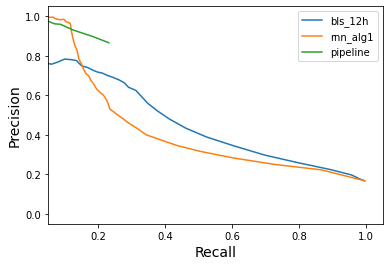

In [143]:
dontshow=[]
onlyshow=[]
# onlyshow=["rnn_sde_alg1"]
combined_results = {**bls_results, **rnn_results, **pipeline_results}
for mname, dic in combined_results.items():
    if len(onlyshow)>0:
        if mname in onlyshow:
            plt.plot(get_recall(dic), get_precision(dic), label=mname)
#             plt.scatter(get_recall(dic), get_precision(dic), label=mname, s=2)
    elif mname not in dontshow:
        plt.plot(get_recall(dic), get_precision(dic), label=mname)
#         plt.scatter(get_recall(dic), get_precision(dic), label=mname, s=2)
plt.legend(), plt.xlim(0.05,1.05), plt.ylim(-0.05,1.05)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

In [145]:
results = rnn_results
mname = "rnn_alg1"
np.array(results[mname]["tp"]) + np.array(results[mname]["fn"])

array([3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285, 3285,
       3285])

In [177]:
def wilson(bool_array, conf=0.95):
    # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    n = bool_array.size
    z = 1.96 
    if conf != 0.95:
        print("WARNING: using conf=0.95")  
    phat = bool_array.mean()
    mean = 1/(1+z**2/n) * (phat + z**2/(2*n))
    unc = z/(1+z**2/n) * np.sqrt(phat*(1-phat)/n + z**2/(4*n**2))
    return mean, unc

def get_bin_indc(array, n_bins=10):
    stepsize = (array.max()-array.min()+1e-9)/n_bins
    bin_indc = []
    minimum = array.min()
    steps = [minimum+stepsize/2+i*stepsize for i in range(n_bins)]
    for bi in range(n_bins):
        low = minimum + bi*stepsize
        high = minimum + (bi+1)*stepsize
        bin_indc.append( np.where((array>=low)*(array<high))[0] )
    return bin_indc, np.array(steps)

def vs_plot(steps, stats, n_samples, xlbl="", legend=False, labels=None, offset=0.1, fill=True, rot=0, 
            min_acc=0.5, max_acc=1.02):
    plt.figure(figsize=(5,3),facecolor="w")
    offs = 0
    for i,stat in enumerate(stats):
        if fill:
            p = plt.plot(steps, stat["mean"], label=labels[i])
            plt.fill_between(steps, np.array(stat["mean"])-np.array(stat["unc"]), 
                             np.array(stat["mean"])+np.array(stat["unc"]), alpha=.3, color=p[0].get_color())
        else:
            plt.errorbar(steps+offs, stat["mean"], yerr=stat["unc"], capsize=2, label=labels[i])
        if offset:
            offs += offset*(steps[1]-steps[0])
    if rot:
        plt.xticks(fontsize=13, rotation=rot, ha='right')
    else:
        plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Fraction correct", fontsize=14)
    plt.xlabel(xlbl, fontsize=14)
    plt.xlim(steps[0]-0.5*(steps[1]-steps[0]),steps[-1]+0.5*(steps[1]-steps[0]))
    plt.ylim(min_acc,max_acc)
    if legend:
#         plt.legend(loc="center right", framealpha=1, fontsize=12, facecolor="w", ncol=1)
        plt.legend(bbox_to_anchor=(1,1.5), framealpha=1, fontsize=12, facecolor="w", ncol=1)
    ax = plt.twinx()
    plt.bar(steps, n_samples, alpha=0.2, color="gray", width=(steps[1]-steps[0]), label="Samples", zorder=0)
    plt.ylabel("#samples", fontsize=14)
    plt.yticks(fontsize=13)
    if legend:
        plt.legend(loc="lower left", framealpha=1, fontsize=12)
    
def plot_1d(model_correct, array, labels, n_bins=10, xlbl="", legend=True, offset=0.01, fill=True, show=True, rot=0, 
            min_acc=0.5, max_acc=1.02):
    bin_indc, steps = get_bin_indc(array, n_bins=n_bins)
    n_samples = np.array([len(indc) for indc in bin_indc])
    
    model_confs = {model:{"mean":[],"unc":[]} for model in labels}
    for indc in bin_indc:
        if len(indc)==0:
            for model in model_confs:
                model_confs[model]["mean"].append(np.nan)
                model_confs[model]["unc"].append(np.nan)
        else:
            for i, model in enumerate(model_confs):
                mean, unc = wilson(model_correct[i][indc])
                model_confs[model]["mean"].append(mean)
                model_confs[model]["unc"].append(unc)
    vs_plot(steps, list(model_confs.values()), n_samples, xlbl, legend, labels, offset=offset, 
            fill=fill, rot=rot, min_acc=min_acc, max_acc=max_acc)
    if show:
        plt.show()

In [178]:
def get_scores(mname, detect_dic, results_dic, thresholds, precision_lvl=0.9, return_sampleids=False):
    thresh = get_threshold(results_dic[mname], thresholds, precision_lvl=0.9)[0]
    correct_detections = [] 
    sampleids = []
    for i in meta:
        for pl_i in meta[i]:
            sampleids.append(f"{i}-{pl_i}")
            correct = False
            for score, det in detect_dic[i][mname].items():
                if score > thresh and correct_detection(det, meta[i][pl_i], int(i.split("-")[0]),
                                                        per_frac=0.01, dur_factor=1, warnings=0):
                    correct=True
                    break
            correct_detections.append(correct)
    if return_sampleids:
        return np.array(correct_detections), np.array(sampleids)
    return np.array(correct_detections)

def get_data_params(meta, pname, fn=lambda a:a):
    lst = []
    for i in meta:
        for pl_i in meta[i]:
            lst.append(fn(meta[i][pl_i][pname]))
    return np.array(lst)

In [179]:
rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, return_sampleids=1)
bls_scores = get_scores("bls_12h", bls_detections, bls_results, bls_thresholds)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds)

In [180]:
ror = get_data_params(meta, "ror")
depth = get_data_params(meta, "depth")
t0 = get_data_params(meta, "t0")
duration = get_data_params(meta, "duration", lambda a:a*24)
a = get_data_params(meta, "a")
period = get_data_params(meta, "orb_period")

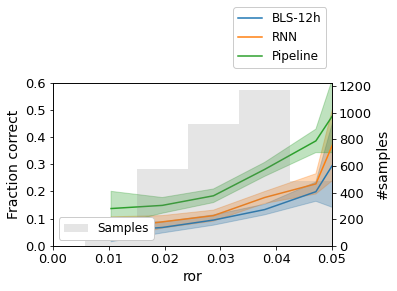

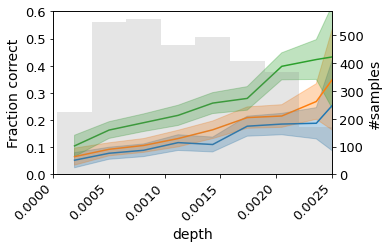

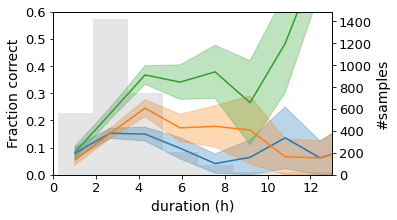

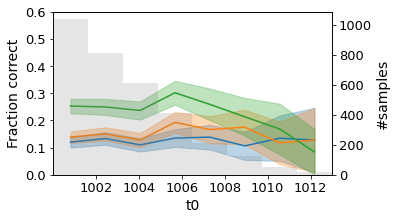

In [214]:
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         ror, labels=["BLS-12h","RNN", "Pipeline"], xlbl="ror", 
         legend=True, n_bins=25, offset=0.1, fill=True, min_acc=0, max_acc=0.6, show=0)
plt.xlim(0,0.05)
plt.show()

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         depth, labels=["BLS-12h","RNN", "Pipeline"], xlbl="depth", 
         legend=False, n_bins=200, offset=0.1, fill=True, min_acc=0, max_acc=0.6, show=0, rot=45)
plt.xlim(0,0.0025)
plt.show()

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         duration, labels=["BLS-12h","RNN", "Pipeline"], xlbl="duration (h)", 
         legend=False, n_bins=90, offset=0.1, fill=True, min_acc=0, max_acc=0.6, show=0)
plt.xlim(0,13)
plt.show()

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         t0, labels=["BLS-12h","RNN", "Pipeline"], xlbl="t0", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, max_acc=0.6, show=0)
# plt.xlim(0,13)
plt.show()